In [1]:
from __future__ import print_function
import time
import torch
import torch.optim as optim

import data_helper as dh
from data_helper import get_variable
from model import *
from masked_cross_entropy import *
import show as sh


import train_helper as th

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

In [7]:
data_dir = './data'
en_file = "{}/{}".format(data_dir, "seg_en_100000")
zh_file = "{}/{}".format(data_dir, "seg_zh_100000")
TARGET_MAX_LEN = 25
USE_CUDA = False
pairs, input_lang, target_lang = dh.read_data(en_file, zh_file, 20000)
print (input_lang.n_words, target_lang.n_words)

./data/seg_en_100000: read 20000
./data/seg_zh_100000: read 20000
12187 18197


In [8]:
# 去掉出现1次的英文单词
input_lang.trim(2)

keep words: 5762 / 12187 = 0.473


In [9]:
# 去掉包含英文单词出现次数=1的pair
pairs = dh.remove_pairs(pairs, 0, lang=input_lang)

keep: 14848 / 20000 = 0.742


In [15]:
# 模型配置
encoder_bidir = False
score_method = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.1

# 优化配置
clip = 50.0
teacher_forcing_ratio = 0.5
learning_rate = 0.0001
decoder_learning_ratio = 5.0

# 训练配置
# n_epochs = 50000
# epoch = 0
# plot_every = 20
# print_every = 100
# evaluate_every = 1000
n_epochs = 1000
epoch = 0
plot_every = 20
print_every = 10
evaluate_every = 500
save_every = 1000
model_dir = './models/1017'
batch_size = 50

train_conf = {'clip': clip, 'teacher_forcing_ratio': teacher_forcing_ratio}

# 初始化模型
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers=n_layers, 
                     dropout_p=dropout_p, bidir=encoder_bidir)
decoder = AttnDecoderRNN(hidden_size, target_lang.n_words, score_method=score_method, 
                         n_layers=n_layers, dropout_p=dropout_p)

# 优化器和loss
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
# criterion = nn.CrossEntropyLoss()

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

print (encoder)
print (decoder)

start = time.time()
plot_losses = []
print_loss_total = 0
plot_loss_total = 0

EncoderRNN (
  (embedding): Embedding(5765, 500)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
)
AttnDecoderRNN (
  (embedding): Embedding(18197, 500)
  (embedding_dropout): Dropout (p = 0.1)
  (gru): GRU(500, 500, num_layers=2, dropout=0.1)
  (concat): Linear (1000 -> 500)
  (out): Linear (500 -> 18197)
  (attn): Attn (
    (attn): Linear (500 -> 500)
  )
)


In [ ]:
ecs = []
dcs = []
eca = 0
dca = 0

# vis = sh.vis
# hostname = sh.HOSTIP

while epoch < n_epochs:
    epoch += 1
    input_batches, input_lengths, target_batches, target_lengths = dh.random_batch(
        batch_size, pairs, input_lang, target_lang)
    loss, ec, dc = th.train(input_batches, input_lengths,
                         target_batches, target_lengths, encoder, decoder,
                         encoder_optimizer, decoder_optimizer, train_conf)
    print_loss_total += loss
    plot_loss_total += loss
    eca += ec
    dca += dc
    #job.record(epoch, loss)
    
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (sh.time_since(start, float(epoch) / n_epochs),
                                               epoch, epoch / n_epochs * 100, print_loss_avg)
        print (print_summary)
    
    if epoch % evaluate_every == 0:
        th.evaluate_randomly(pairs, input_lang, target_lang, encoder, decoder, False, False, False)
    
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
    
    if epoch % save_every == 0:
            no = epoch / save_every
            to = n_epochs / save_every
            s = '{}_{}'.format(no, to)
            torch.save(encoder, model_dir + '/' + s + 'encoder.pkl')
            torch.save(encoder, model_dir + '/' + s + 'decoder.pkl')
            print ('epoch=%d saved model' % epoch)

5m 7s (- 506m 37s) (10 1%) 8.6112
9m 17s (- 455m 39s) (20 2%) 6.4452
12m 26s (- 402m 4s) (30 3%) 6.1788
15m 43s (- 377m 20s) (40 4%) 6.0823
19m 21s (- 367m 49s) (50 5%) 5.9394
22m 38s (- 354m 40s) (60 6%) 5.8474
26m 20s (- 349m 56s) (70 7%) 5.7475
30m 5s (- 346m 8s) (80 8%) 5.7462
36m 52s (- 331m 55s) (100 10%) 5.5919
41m 4s (- 332m 22s) (110 11%) 5.5926
45m 6s (- 330m 50s) (120 12%) 5.5923
50m 31s (- 338m 10s) (130 13%) 5.5779
57m 27s (- 352m 55s) (140 14%) 5.4733
63m 18s (- 358m 45s) (150 15%) 5.4597
69m 6s (- 362m 47s) (160 16%) 5.3702
76m 31s (- 373m 37s) (170 17%) 5.4695
81m 56s (- 373m 16s) (180 18%) 5.3498
88m 52s (- 378m 55s) (190 19%) 5.4029
95m 1s (- 380m 6s) (200 20%) 5.3448
101m 11s (- 380m 38s) (210 21%) 5.3765
104m 45s (- 371m 25s) (220 22%) 5.2361
108m 55s (- 364m 38s) (230 23%) 5.1857
112m 0s (- 354m 41s) (240 24%) 5.1633
116m 8s (- 348m 25s) (250 25%) 5.2061
119m 50s (- 341m 6s) (260 26%) 5.1115
126m 13s (- 341m 15s) (270 27%) 5.1609
132m 43s (- 341m 17s) (280 28%) 5.2

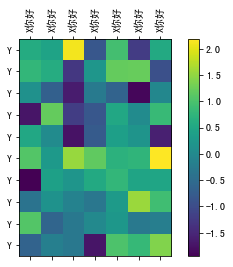

In [2]:
def show_attention(input_sentence, output_words, attentions, target_sentence=None):
    ''' axis=0 y 垂直, axis=1 x水平
    Args:
        attentions: [t, s]
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # [s, t] < [t, s]
    print ('before:', attentions.size())
    # attentions = attentions.transpose(0, 1).numpy()
    print ('after:', attentions.size())
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    xlabels = [''] + input_sentence.split(' ') + ['<EOS>']
    ylabels = [''] + output_words
    print (len(xlabels), len(ylabels))
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_yticklabels(ylabels)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def test_plot():
    '''
     axis=0 y 垂直, axis=1 x水平
    '''
    fig = plt.figure()
    plt.rcParams['font.sans-serif']=['simhei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
    #matplotlib.rcParams['axes.unicode_minus'] = False   #-号为方块问题
    ax = fig.add_subplot(111)
    content = torch.randn(10, 7)
    cax = ax.matshow(content.numpy())
    fig.colorbar(cax)
    xlabels = ['你好'] * (content.size(1) + 1)
    ylabels = [''] * (content.size(0) + 1)
    # axes x-0真实的，y-1预测的
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_yticklabels(ylabels)

    # force label at every tick，否则只会隔几个显示一下
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

test_plot()

/home/plm/anaconda3/lib/python3.6/site-packages/torch/tensor.py:297: UserWarning: other is not broadcastable to self, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.add_(other)


input_length:8, di=24, size=torch.Size([25, 8])
a devoted husband , loving father ,
['炮火', '杜绝', '杜绝', '杜绝', '界线', '界线', '炮火', '胡说', '挡', '恐龙蛋', '恐龙蛋', '恐龙蛋', '恐龙蛋', '恐龙蛋', '恐龙蛋', '收手', '恐龙蛋', '恐龙蛋', '恐龙蛋', '收手', '杜绝', '杜绝', '侦察', '侦察', '炮火']
torch.Size([25, 8])
before: torch.Size([25, 8])
after: torch.Size([25, 8])
9 26


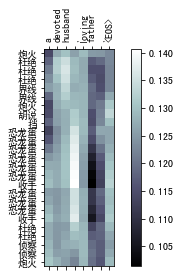

In [6]:
# test show attention
[input_sentence, target_sentence] = random.choice(pairs)

# th.evaluate_sentence(input_sentence, input_lang, target_lang,
#                   encoder, decoder, target_sentence=target_sentence, True, True, False)
output_words, attentions = th.evaluate(input_sentence, input_lang, target_lang, 
                                       encoder, decoder)
print (input_sentence)
print (output_words)
print (attentions.size())
show_attention(input_sentence, output_words, attentions, target_sentence)